In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
%load_ext autoreload
%autoreload 2

### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

In [3]:
def parse_model_info(model_name):
    model_name = model_name.replace('.pth', '')
    model_name = model_name.split('_')
    model_type = model_name[0] + '_' + model_name[1]
    if len(model_name) == 8:    
        activation = model_name[2] + '_' + model_name[3]
        hidden_size = int(model_name[4])
        learning_rate = float(model_name[5])
        batch_size = int(model_name[6])
    else:
        activation = model_name[2]
        hidden_size = int(model_name[3])
        learning_rate = float(model_name[4])
        batch_size = int(model_name[5])
    return model_type, activation, hidden_size, learning_rate, batch_size

parse_model_info('leaky_gru_leaky_relu_128_0.001_128_train.pth')



('leaky_gru', 'leaky_relu', 128, 0.001, 128)

### Get dissimilarities

#### Computation dynamics

In [4]:
measures = ["cka", "dsa", "procrustes"]
dissimilarities = {measure: [] for measure in measures}

groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]


def symmetric(array):
    for i in range(array.shape[0]):
        for j in range(i, array.shape[1]):
            array[j, i] = array[i, j]
    return array


# function to replace all nan which are on diagonal of an array
def replace_nan_diagonal(array):
    for i in range(array.shape[0]):
        if np.isnan(array[i, i]):
            array[i, i] = 0
    return array


def replace_nan_diagonal_list(arrays):
    return [replace_nan_diagonal(arr) for arr in arrays]

# function to remove among list of arrays the ones which have nan values within array
def remove_nan(array):
    return array if not np.isnan(np.sum(array)) else None

def remove_nan_list(lists):
    return [remove_nan(arr) for arr in lists]

In [5]:
path = f"../data/dissimilarities/{taskset}/"
df = {"model_type":[], "activation":[], "hidden_size":[], "lr":[], "batch_size":[], "group1":[], "group2":[],"measure":[], "dissimilarity":[]} 
for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            model_type, activation, hidden_size, lr, batch_size = parse_model_info(file)
            with np.load(file_path, allow_pickle=True) as data:
                dissimilarities[measure].append(data["arr_0"])
                for i in range(len(groups)):
                    for j in range(len(groups)):
                        array_dissimilarities = remove_nan(
                            replace_nan_diagonal(data["arr_0"])
                        )
                        if array_dissimilarities is not None:
                            array_dissimilarities = symmetric(array_dissimilarities)
                            df["model_type"].append(model_type)
                            df["activation"].append(activation)
                            df["hidden_size"].append(hidden_size)
                            df["lr"].append(lr)
                            df["batch_size"].append(batch_size)
                            df["group1"].append(groups[i])
                            df["group2"].append(groups[j])
                            df["measure"].append(measure)
                            df["dissimilarity"].append(array_dissimilarities[i, j])
df = pd.DataFrame(df)

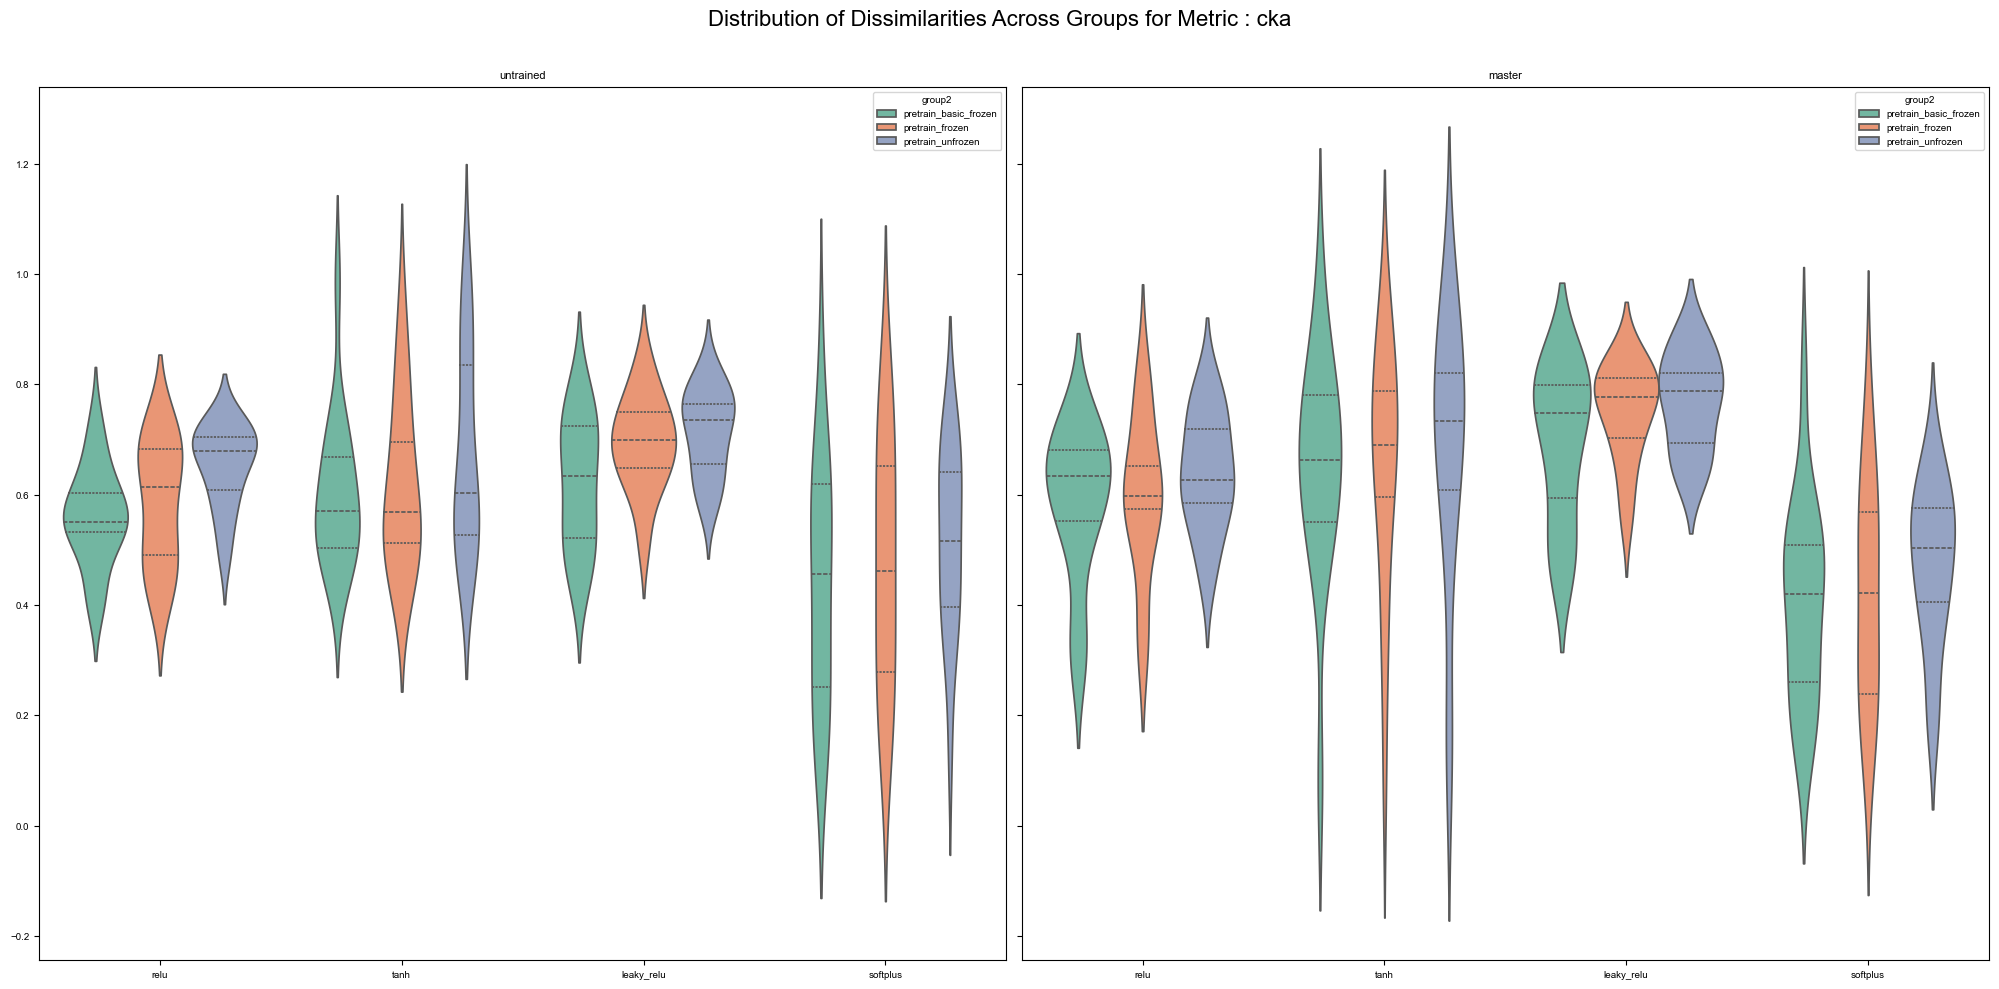

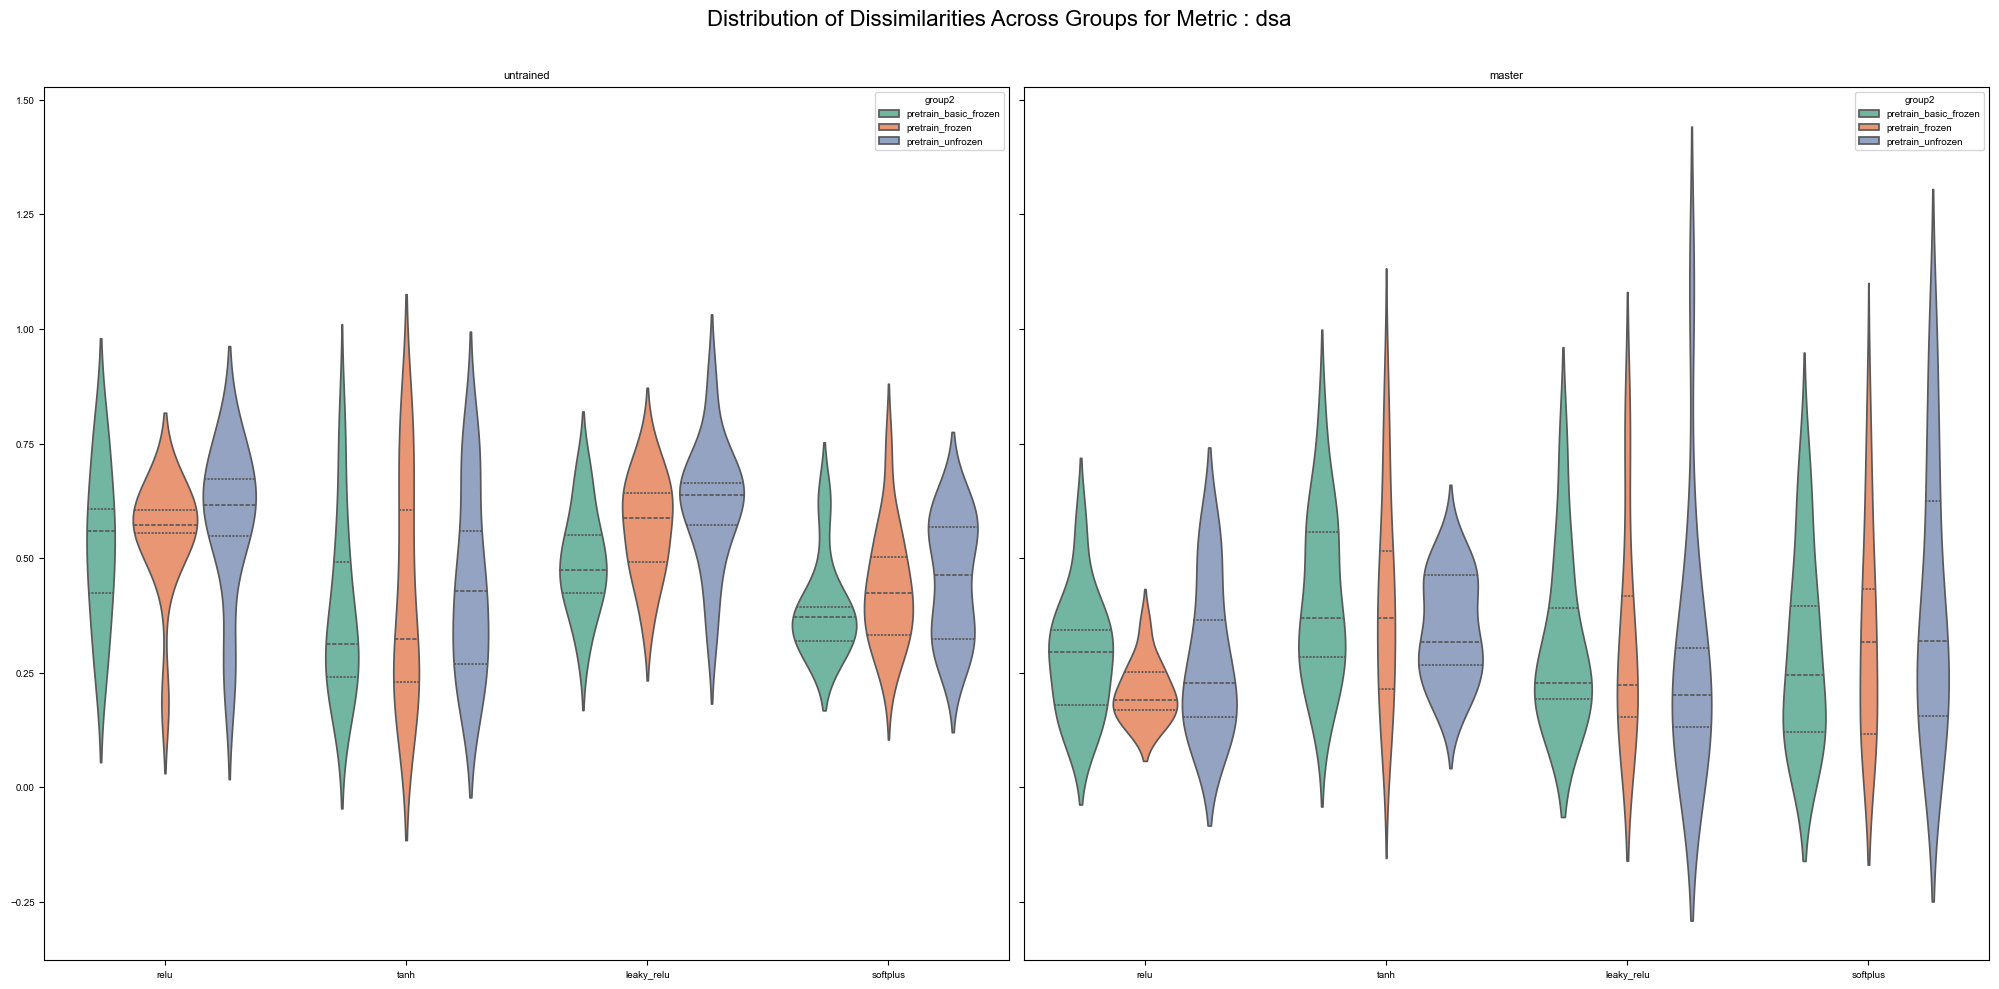

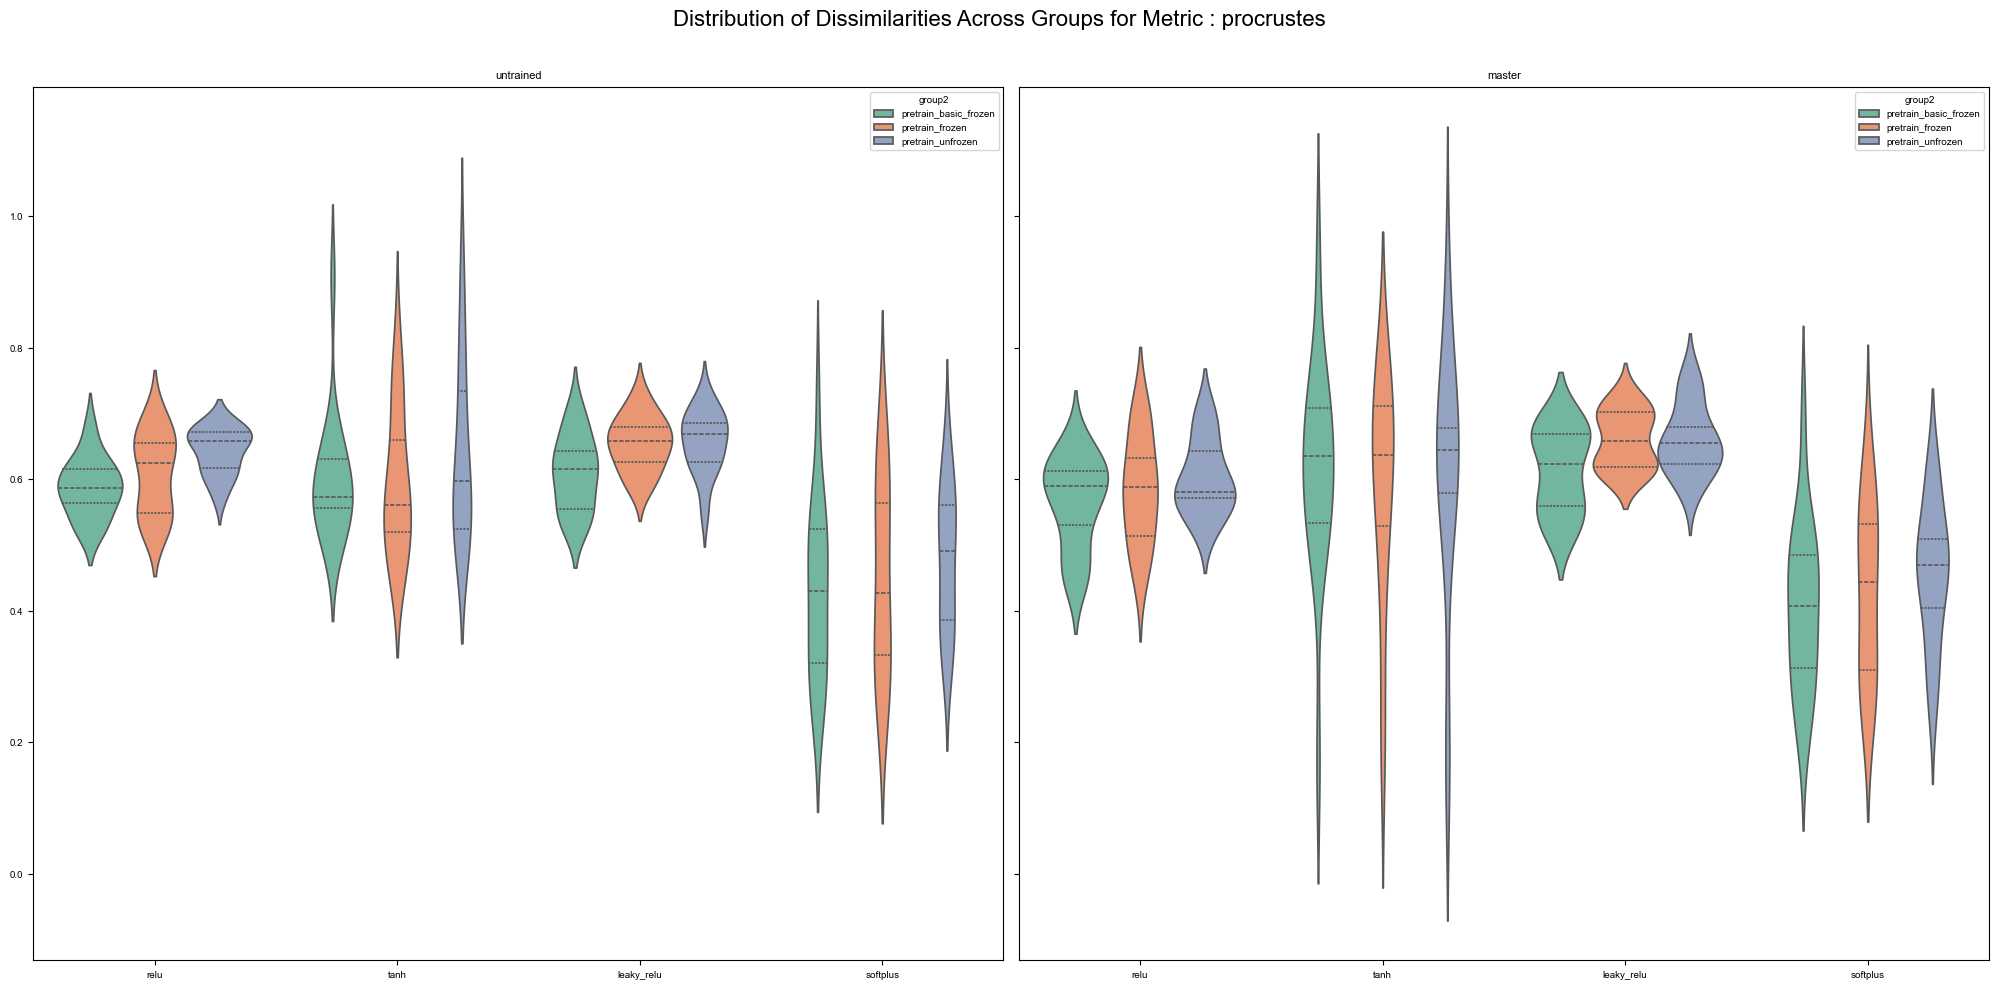

In [6]:
from math import log
groups_base = ["untrained", "master"]
groups_selected = ["pretrain_basic_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]
for measure in measures:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) &
                (df_selected["measure"] == measure)
            ],
            x="activation",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

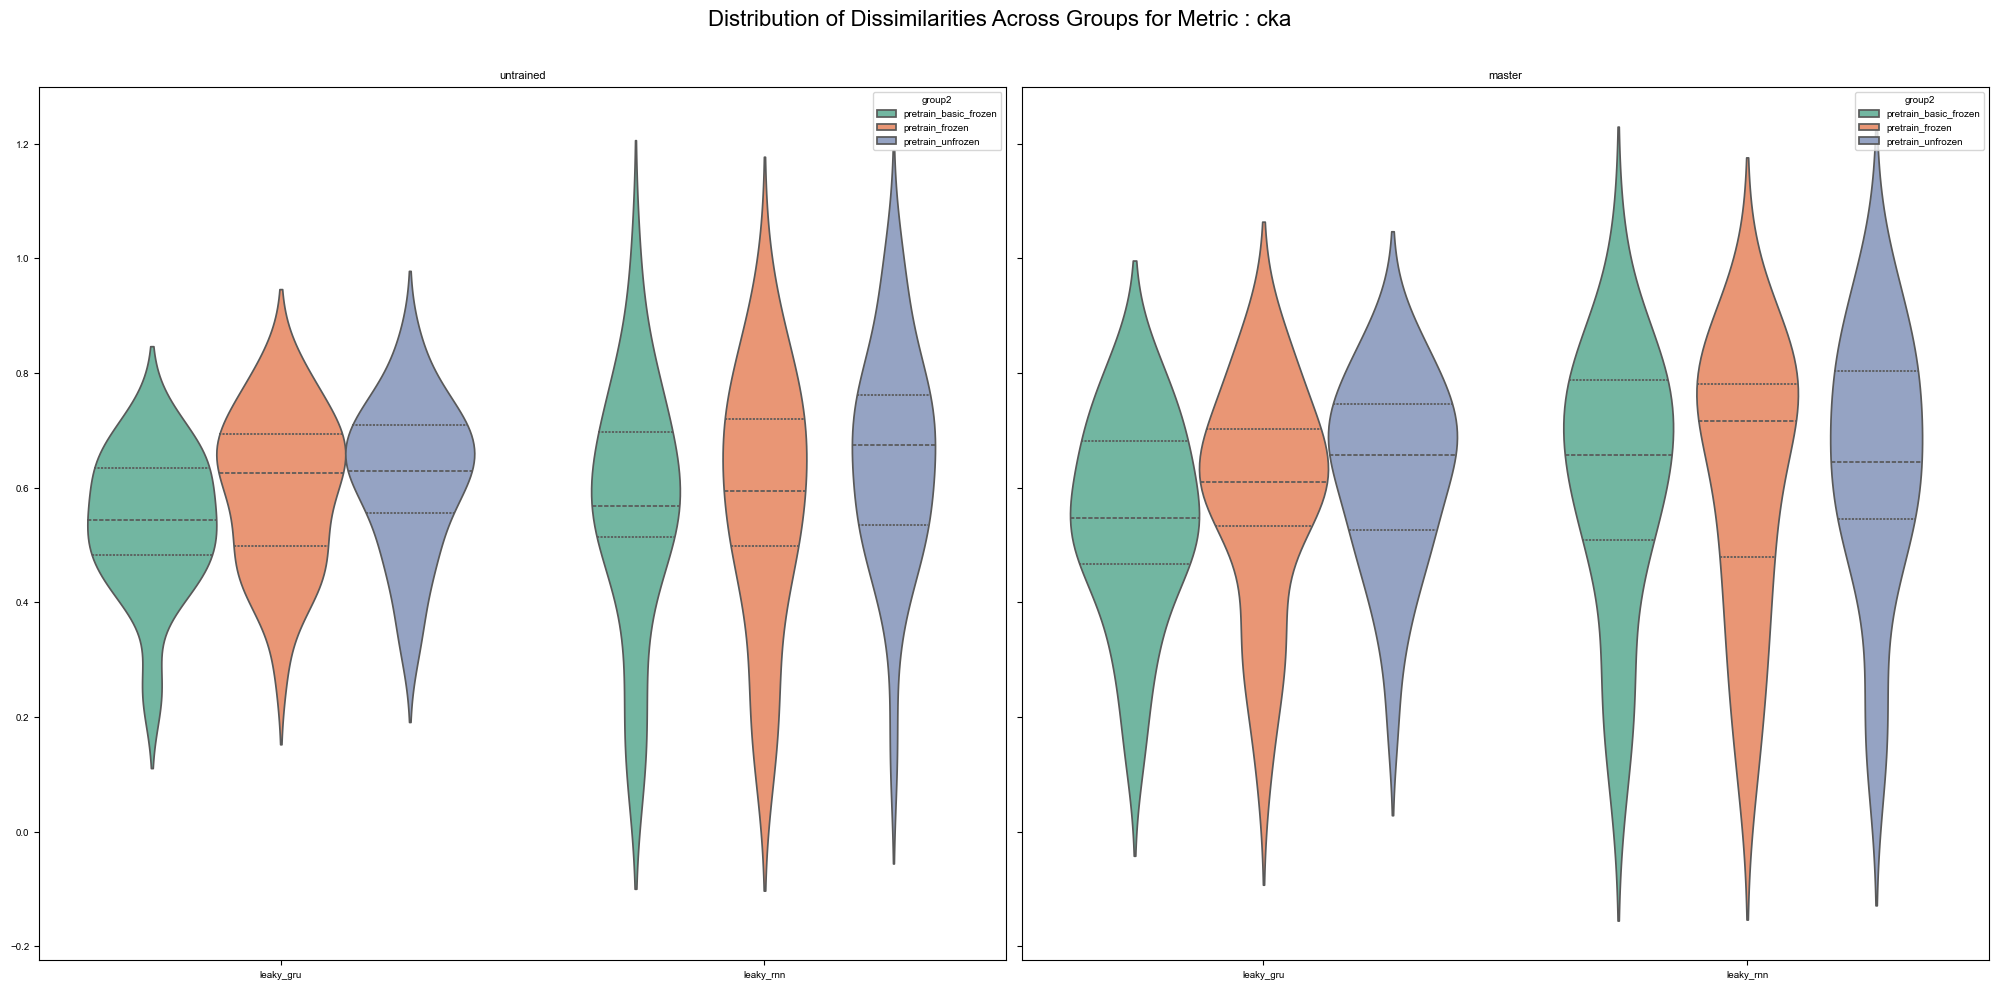

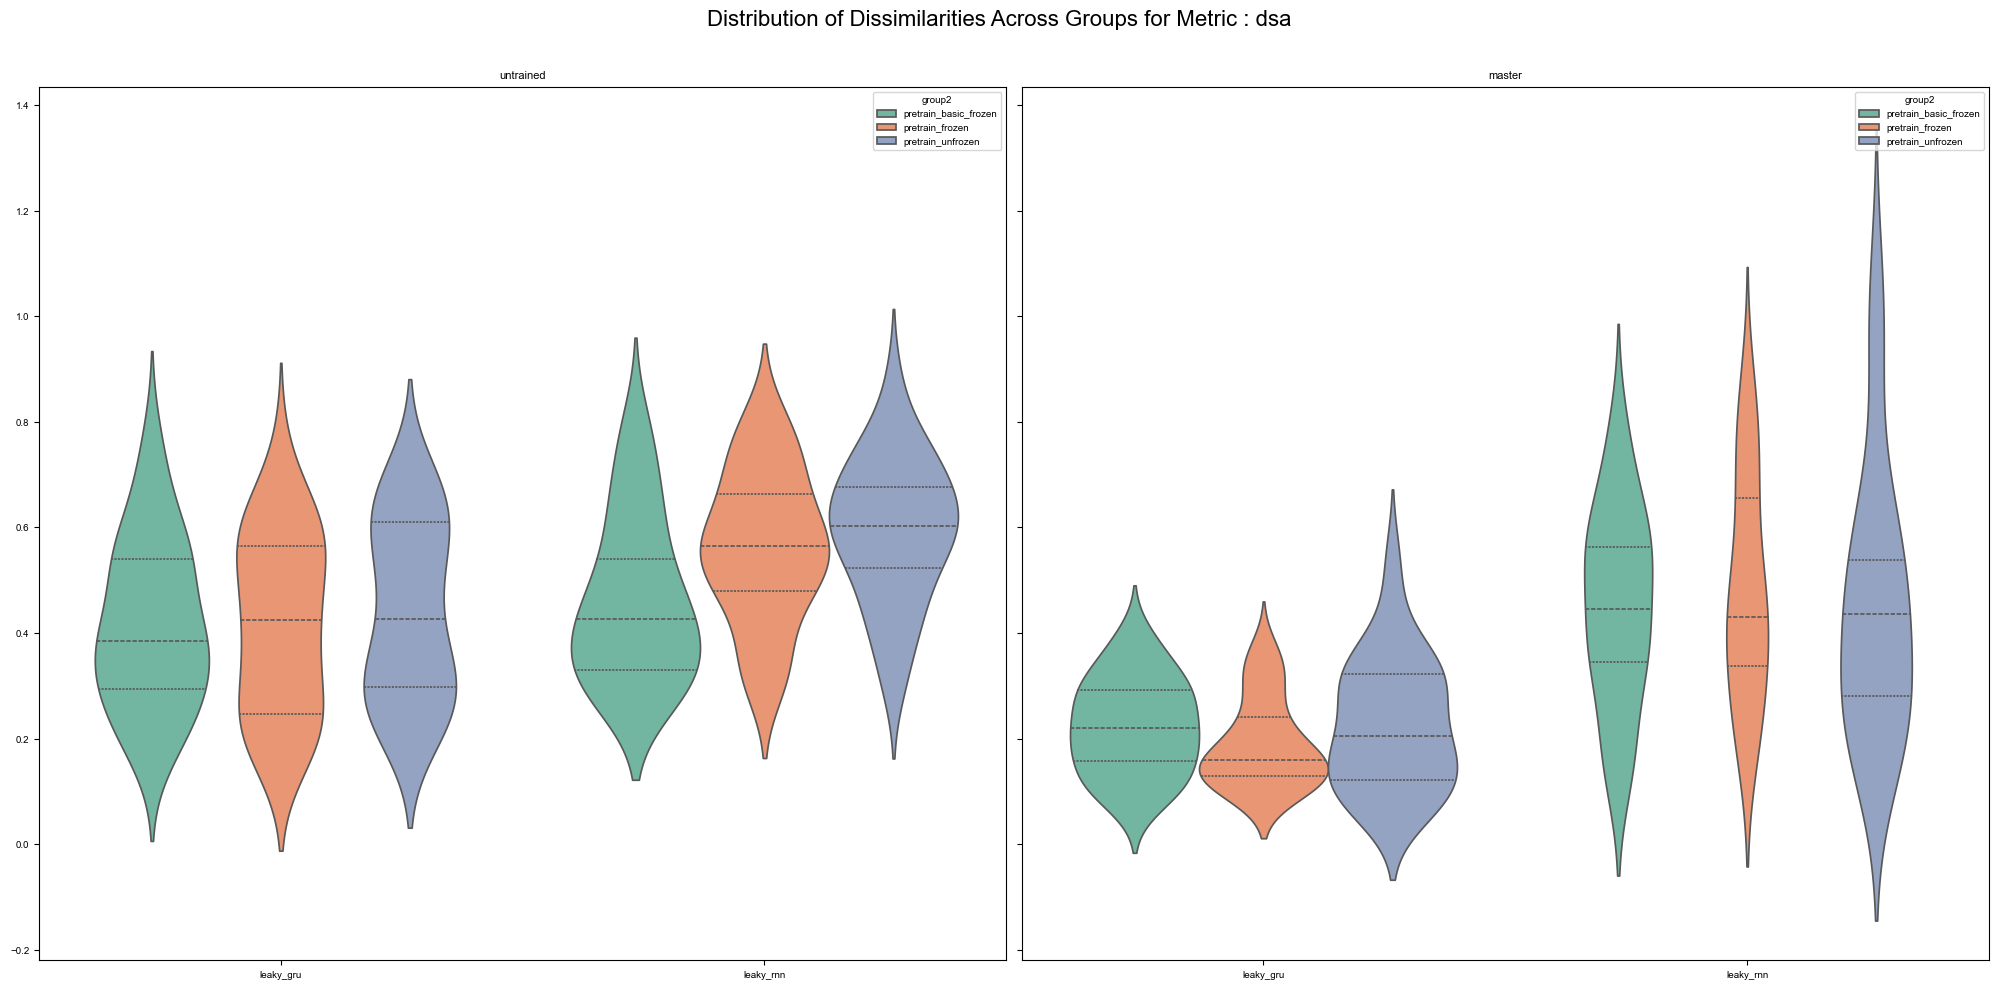

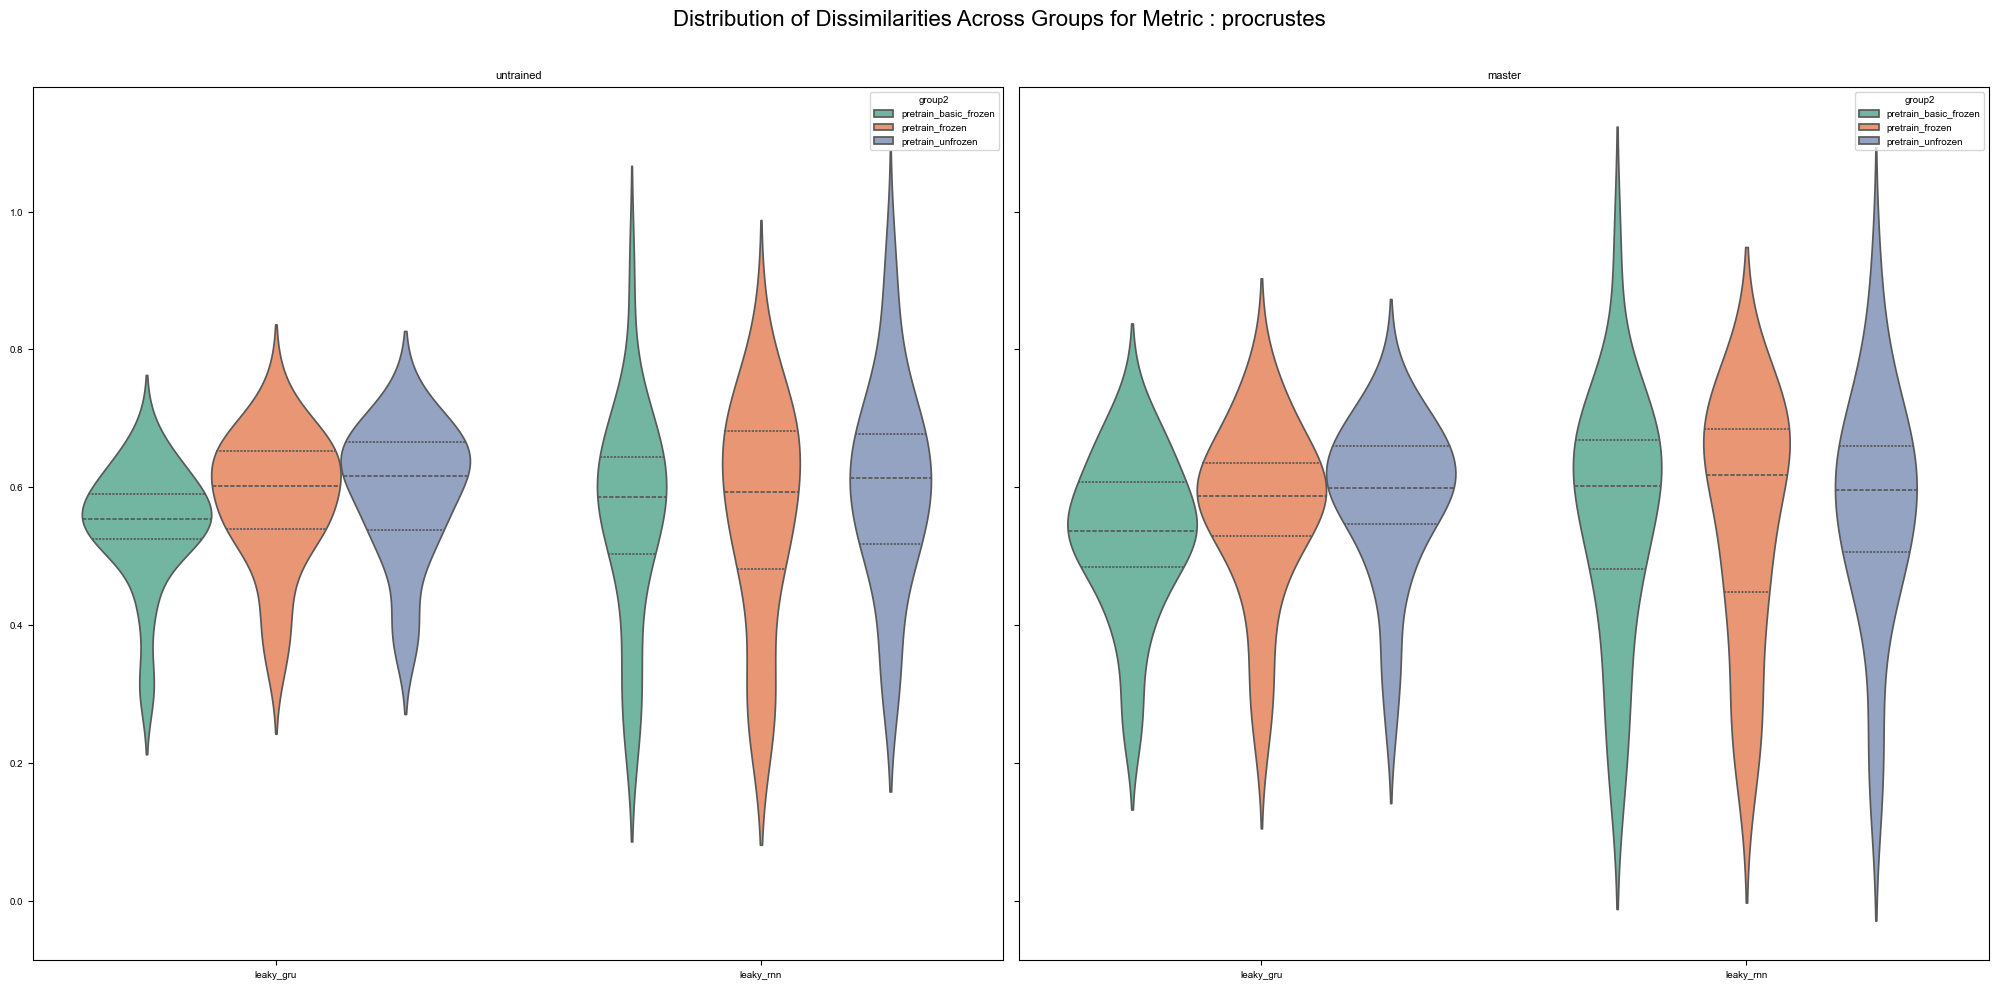

In [7]:
from math import log

groups_base = ["untrained", "master"]
groups_selected = ["pretrain_basic_frozen", "pretrain_frozen","pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]
for measure in measures:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ],
            x="model_type",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [8]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df.groupby(["group1", "group2", "measure"])["dissimilarity"].median().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

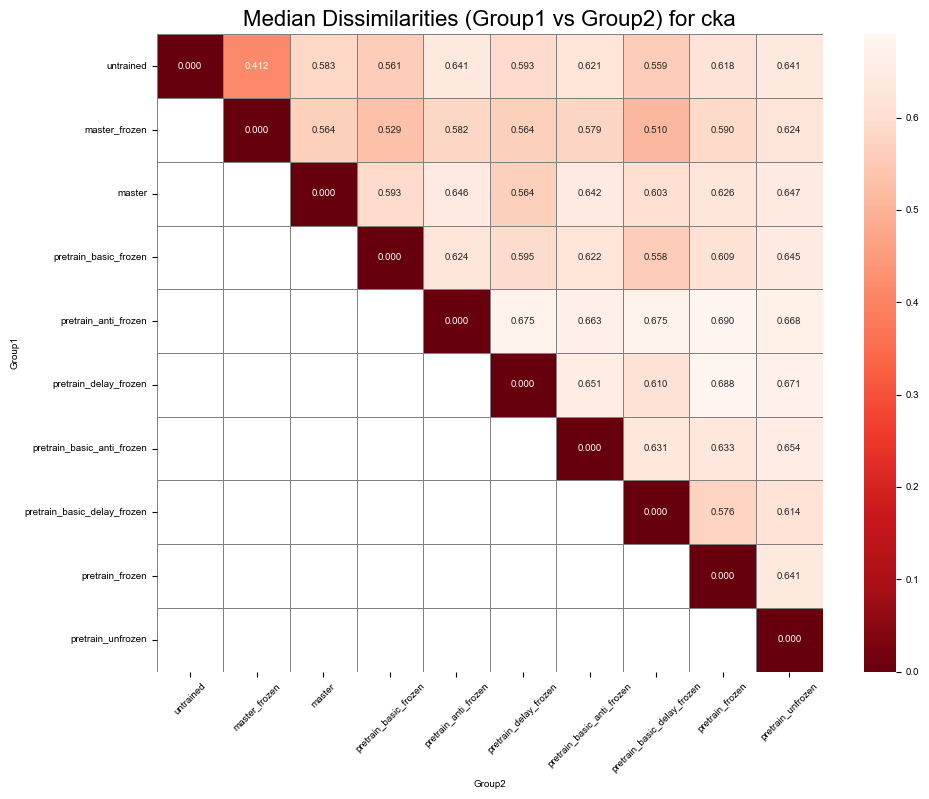

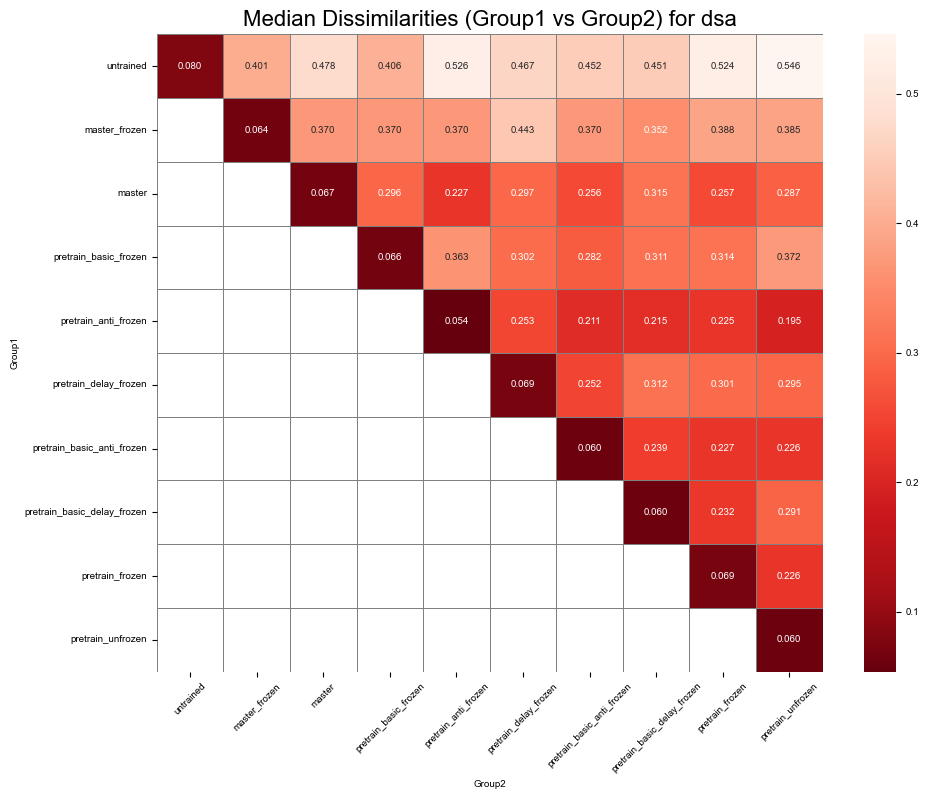

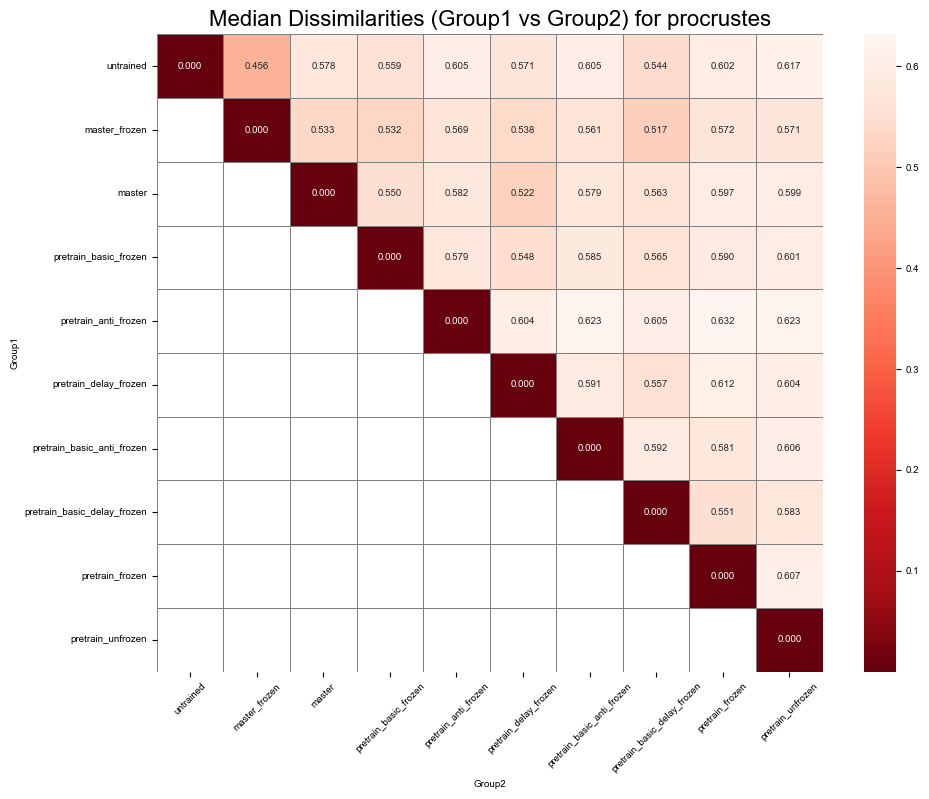

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [10]:
# unique groups :
from asyncio import tasks


groups = list(config[taskset]["groups"].keys())
# generate all possible pairs of groups
pairs = [
    (groups[i], groups[j]) for i in range(len(groups)) for j in range(i, len(groups))
]
# group pairs of groups by how many tasks they share in their training curriculum
group_pairs = {}
for pair in pairs:
    group1, group2 = pair
    group1_tasks = (
        config[taskset]["groups"][group1]["pretrain"]["ruleset"]
        + config[taskset]["groups"][group1]["train"]["ruleset"]
        if config[taskset]["groups"][group1]["train"]["frozen"] == False
        else config[taskset]["groups"][group1]["pretrain"]["ruleset"]
    )
    group2_tasks = (
        config[taskset]["groups"][group2]["pretrain"]["ruleset"]
        + config[taskset]["groups"][group2]["train"]["ruleset"]
        if config[taskset]["groups"][group2]["train"]["frozen"] == False
        else config[taskset]["groups"][group2]["pretrain"]["ruleset"]
    )
    if len(group1_tasks) == 0 and len(group2_tasks) == 0:
        shared_tasks = 100
    elif len(group1_tasks) == 0 or len(group2_tasks) == 0:
        shared_tasks = 0
    else:
        shared_tasks = int(
            100
            * len(set(group1_tasks).intersection(set(group2_tasks)))
            / max(len(group1_tasks), len(group2_tasks))
        )
    try:
        group_pairs[shared_tasks].append(pair)
    except KeyError:
        group_pairs[shared_tasks] = [pair]

In [11]:
group_pairs

{100: [('master', 'master'),
  ('pretrain_frozen', 'pretrain_frozen'),
  ('pretrain_unfrozen', 'pretrain_unfrozen'),
  ('pretrain_basic_frozen', 'pretrain_basic_frozen'),
  ('pretrain_anti_frozen', 'pretrain_anti_frozen'),
  ('pretrain_delay_frozen', 'pretrain_delay_frozen'),
  ('pretrain_basic_anti_frozen', 'pretrain_basic_anti_frozen'),
  ('pretrain_basic_delay_frozen', 'pretrain_basic_delay_frozen'),
  ('master_frozen', 'master_frozen'),
  ('master_frozen', 'untrained'),
  ('untrained', 'untrained')],
 0: [('master', 'pretrain_frozen'),
  ('master', 'pretrain_basic_frozen'),
  ('master', 'pretrain_anti_frozen'),
  ('master', 'pretrain_delay_frozen'),
  ('master', 'pretrain_basic_anti_frozen'),
  ('master', 'pretrain_basic_delay_frozen'),
  ('master', 'master_frozen'),
  ('master', 'untrained'),
  ('pretrain_frozen', 'master_frozen'),
  ('pretrain_frozen', 'untrained'),
  ('pretrain_unfrozen', 'master_frozen'),
  ('pretrain_unfrozen', 'untrained'),
  ('pretrain_basic_frozen', 'pretra

In [12]:
dissimilarities_per_shared_task = {"dsa": {perc:[] for perc in group_pairs.keys()}, "cka":  {perc:[] for perc in group_pairs.keys()}, "procrustes":  {perc:[] for perc in group_pairs.keys()}}
for shared_tasks, pairs in group_pairs.items():
    for pair in pairs:
        group1, group2 = pair
        data_pair = df[
            ((df["group1"] == group1) & (df["group2"] == group2))
            # or the opposite
            | ((df["group1"] == group2) & (df["group2"] == group1))
        ]
        # if pair == ("pretrain_frozen", "pretrain_unfrozen"):
        #     print(data_pair)
        for measure in measures:
            data_pair_mesure = data_pair[data_pair["measure"] == measure]["dissimilarity"].tolist()
            dissimilarities_per_shared_task[measure][shared_tasks].extend(
                data_pair_mesure
            )
            if pair == ("pretrain_frozen", "pretrain_unfrozen"):
                print(f"mesure : {measure}")
                print(f"pair data mesure : {data_pair_mesure}")

mesure : cka
pair data mesure : [0.6729188442796035, 0.6729188442796035, 0.13013458934125977, 0.13013458934125977, 0.6495227727349595, 0.6495227727349595, 0.653872632625167, 0.653872632625167, 0.8240261146191598, 0.8240261146191598, 0.9528140187507187, 0.9528140187507187, 0.8255042396153984, 0.8255042396153984, 0.15276250543172232, 0.15276250543172232, 0.5738476079438037, 0.5738476079438037, 0.3438923743913469, 0.3438923743913469, 0.49660378639823133, 0.49660378639823133, 0.40128833516298545, 0.40128833516298545, 0.24593465108292456, 0.24593465108292456, 0.6258831026817401, 0.6258831026817401, 0.7437494440580421, 0.7437494440580421, 0.9004110406053287, 0.9004110406053287, 0.8470984501570897, 0.8470984501570897, 0.4619313109201937, 0.4619313109201937, 0.38049505177747067, 0.38049505177747067, 0.07016211852293086, 0.07016211852293086, 0.43369237600737287, 0.43369237600737287, 0.8544496541420173, 0.8544496541420173, 0.8086081677391362, 0.8086081677391362, 0.775642798976799, 0.775642798976

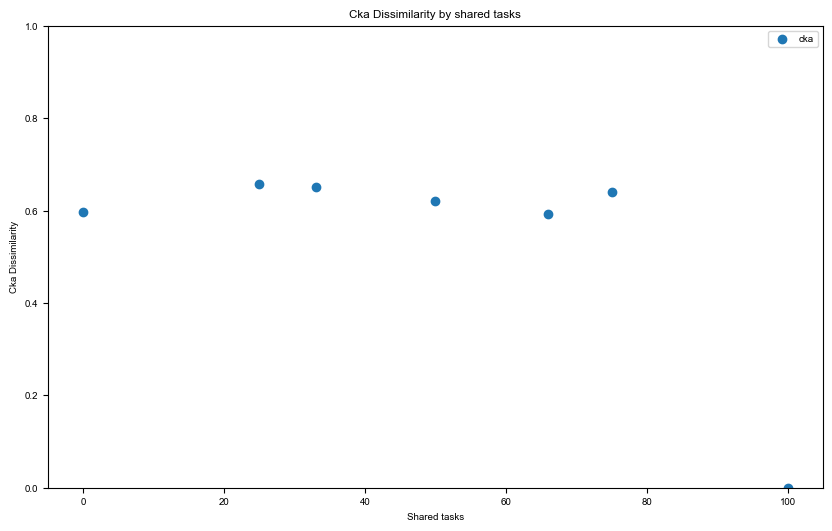

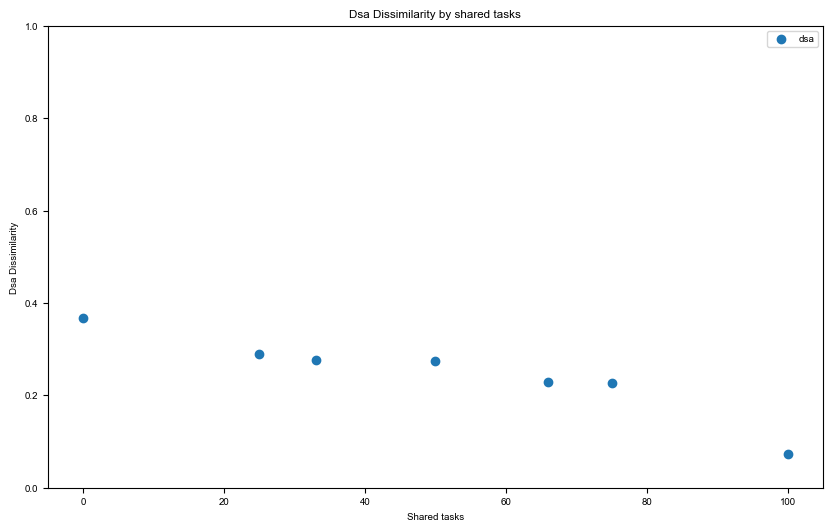

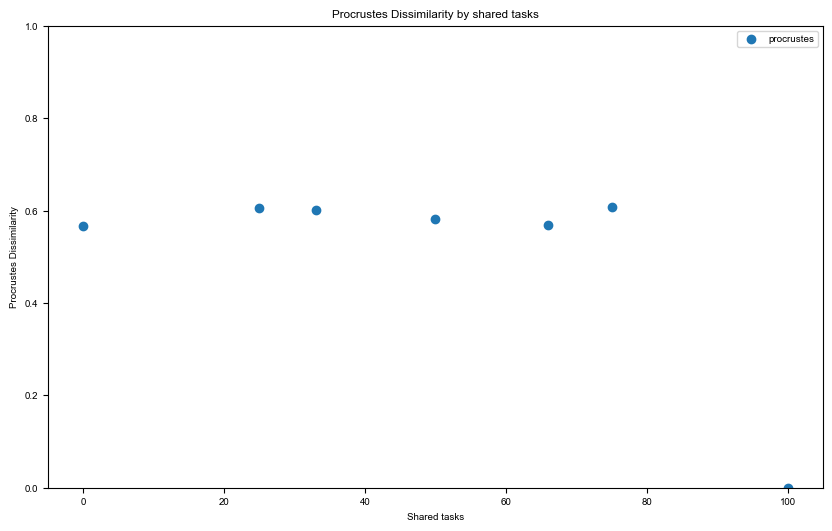

In [13]:
# plot the dissimilarities per shared task by taking median of the dissimilarities for each shared task. shared task as x-axis and dissimilarity as y-axis and do a line plot without errors
for measure in measures:
    dissimilarities_per_shared_task[measure] = {
        k: np.median(v) for k, v in dissimilarities_per_shared_task[measure].items()
    }
    percent_shared_tasks_sorted = sorted(
        list(dissimilarities_per_shared_task[measure].keys())
    )
    dissimilarities = [dissimilarities_per_shared_task[measure][percent] for percent in percent_shared_tasks_sorted]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        percent_shared_tasks_sorted,
        dissimilarities,
        label=measure,
    )
    plt.xlabel("Shared tasks")
    plt.ylim(0, 1)
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity by shared tasks")
    plt.legend()
    plt.show()    

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [14]:
# take all the folder names under data/dissimilarities_over_learning/{taskset}
groups_training = os.listdir(f"../data/dissimilarities_over_learning/{taskset}")
groups_training = [group for group in groups_training if group != ".DS_Store"]
dissimilarities_groups = {
    group: None for group in groups_training
}

for group_training in groups_training: 
    path = f"../data/dissimilarities_over_learning/{taskset}/{group_training}"
    measures = ["cka", "dsa", "procrustes", "accuracy_1", "accuracy_2"]
    sampling = [0, 25, 50, 75, 100]
    dissimilarities = {measure: [] for measure in measures}

    for measure in measures:
        path_measure = os.path.join(path, measure)
        files = os.listdir(path_measure)
        for file in files:
            file_path = os.path.join(path_measure, file)
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    print(data["arr_0"])
                    dissimilarities[measure].append(data["arr_0"])
    dissimilarities_interpolated = {
        measure: {group: [] for group in range(len(sampling))} for measure in measures
    }
    for measure in measures:
        for dissimilarity in dissimilarities[measure]:
            if dissimilarity.shape[0] > 4:
                dissimilarities_interpolated[measure][0].append(dissimilarity[0])
                for i in range(len(sampling) - 1):
                    index_start = int(sampling[i] / 100 * (dissimilarity.shape[0]))
                    index_end = int(sampling[i + 1] / 100 * (dissimilarity.shape[0]))
                    dissimilarities_interpolated[measure][i+1].append(
                        np.median(dissimilarity[index_start:index_end])
                    )
    for measure in measures:
        for group in range(len(sampling)):
            dissimilarities_interpolated[measure][group] = np.mean(
                dissimilarities_interpolated[measure][group]
            )
    dissimilarities_groups[group_training] = dissimilarities_interpolated

[0.43103138 0.41518048 0.42899636 0.4138672  0.39941249 0.38805339
 0.38021809 0.38862896 0.3664     0.38491636 0.3950363  0.35163141
 0.45037361 0.43446612 0.34681166 0.31461185 0.29690294 0.28066856
 0.28368999 0.26562327 0.33119511 0.36816243 0.35065798 0.34042766
 0.33737981 0.33073931 0.33751697 0.31431689 0.32744245 0.30200792
 0.30618714 0.2978537  0.29106878 0.29160642 0.30990307 0.28999403
 0.3042118  0.31015592 0.35769529]
[0.41870628 0.56417253 0.5958938  0.55344315 0.53415954 0.54296705
 0.55233866 0.53420183 0.57654951 0.54863161 0.57667251 0.57738045]
[0.35576259 0.45811802 0.30006999]
[0.28393746 0.33390351 0.46901595 0.68105166 0.80437796 0.80258303]
[0.33607675 0.37181919 0.58835753 0.54716978 0.46000279 0.46887654
 0.40488724 0.45533774 0.43975902 0.45747193 0.47689213 0.44968443
 0.42432486 0.44392288 0.45995652 0.44870313 0.46668651 0.3905769
 0.4097073  0.41652512 0.42176477 0.42413061 0.42546618 0.42776242
 0.42959565 0.42991273 0.4329047  0.43326932 0.43398239 0.

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0.62295294 0.58719984 0.58287994 0.58399565 0.58103616 0.57827769
 0.56954567 0.57335416 0.56600312 0.56728015 0.56509043 0.5565672
 0.55758806 0.55156989 0.55267101 0.55279665 0.54312741 0.54452557
 0.53494376 0.54321343 0.53650806 0.52986279 0.51955248 0.52257734
 0.52813172 0.5250807  0.52512766 0.51761052 0.52072193 0.51751996
 0.53488393 0.52918767 0.53398878 0.53442181 0.51678524 0.52423962
 0.52342899 0.52551351 0.52574216 0.51136758 0.52070249 0.51857009
 0.5114123  0.52375275 0.50894584 0.51759735 0.50109002 0.51114447
 0.511211   0.51687129]
[0.68481399 0.65871767 0.65784944 0.67044455 0.67028208 0.66826378
 0.66908126 0.66386368 0.66116989 0.66346405 0.66801205 0.66279303]
[0.65658258 0.56916946 0.53204675 0.50229551 0.47975159 0.45840722]
[0.42036111 0.39526306 0.37310275 0.38604379 0.36960742 0.42257992
 0.44237113 0.39177608 0.41644843 0.42986183 0.4024381  0.43002428
 0.43084055 0.43490322 0.44520282 0.45032379 0.45116728 0.44454452
 0.44653339 0.44002948 0.4443218  0.4

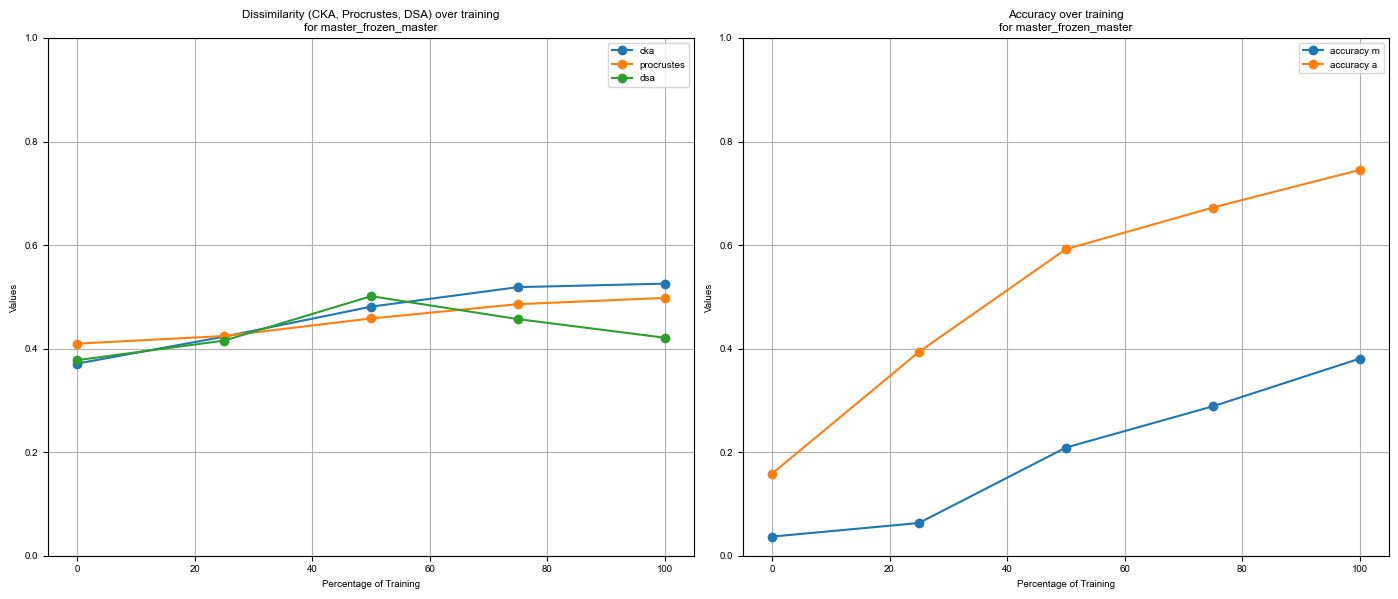

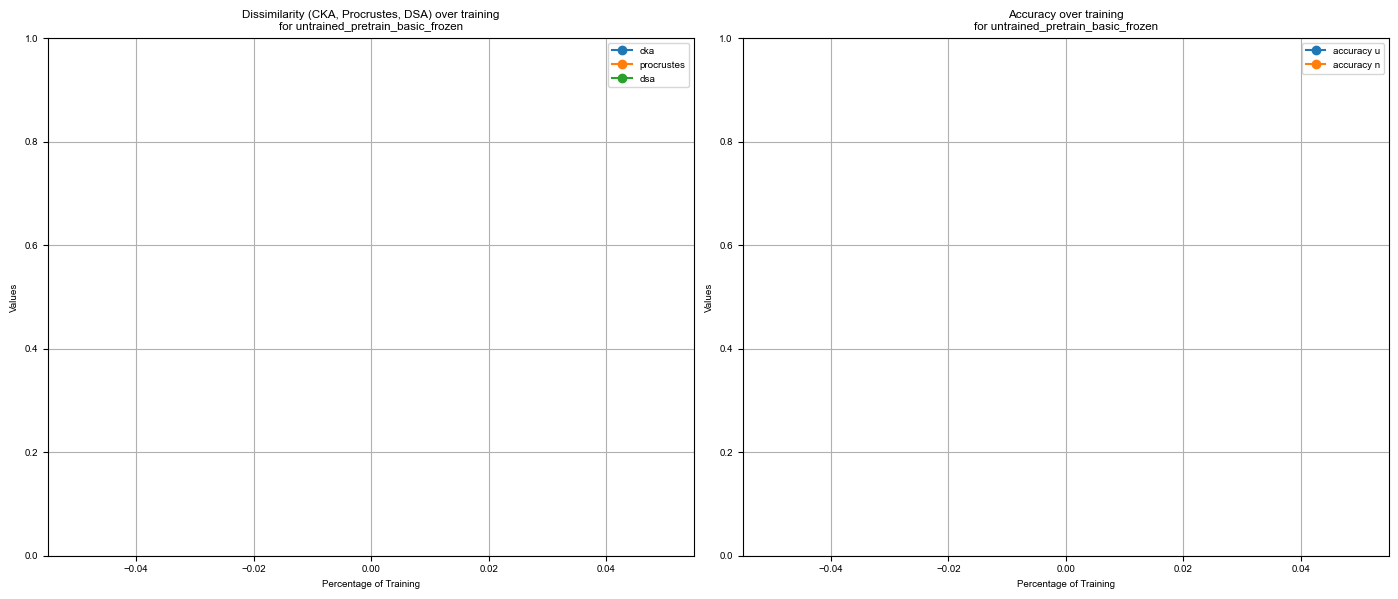

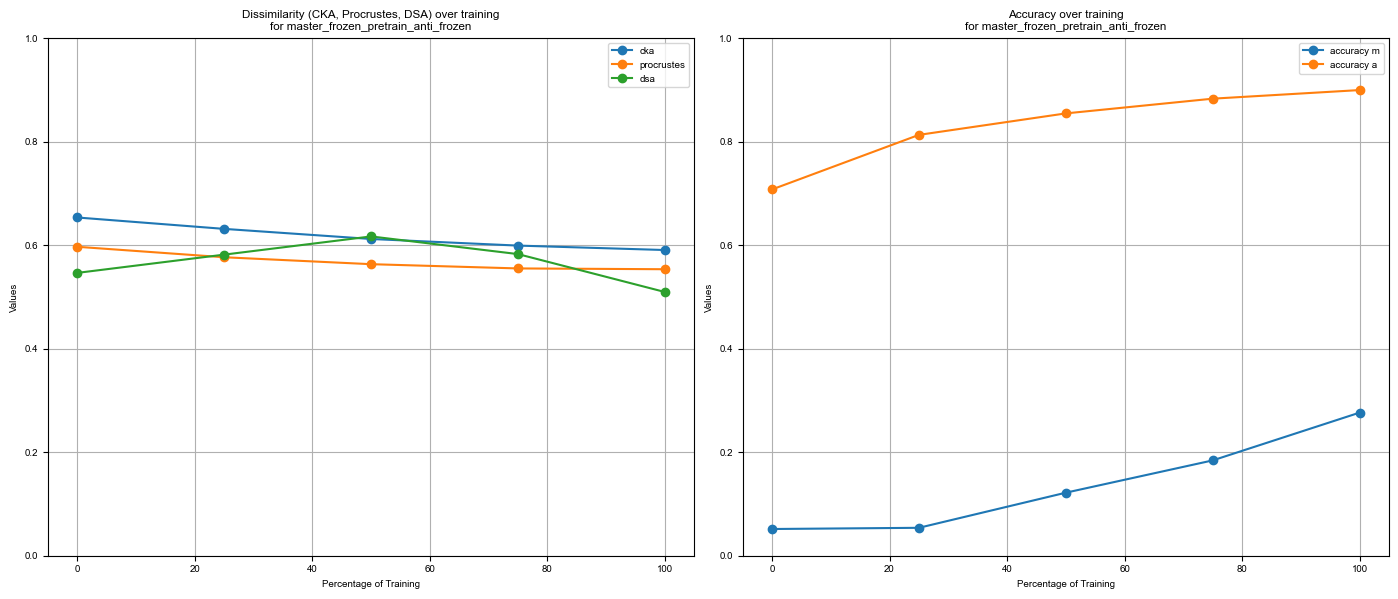

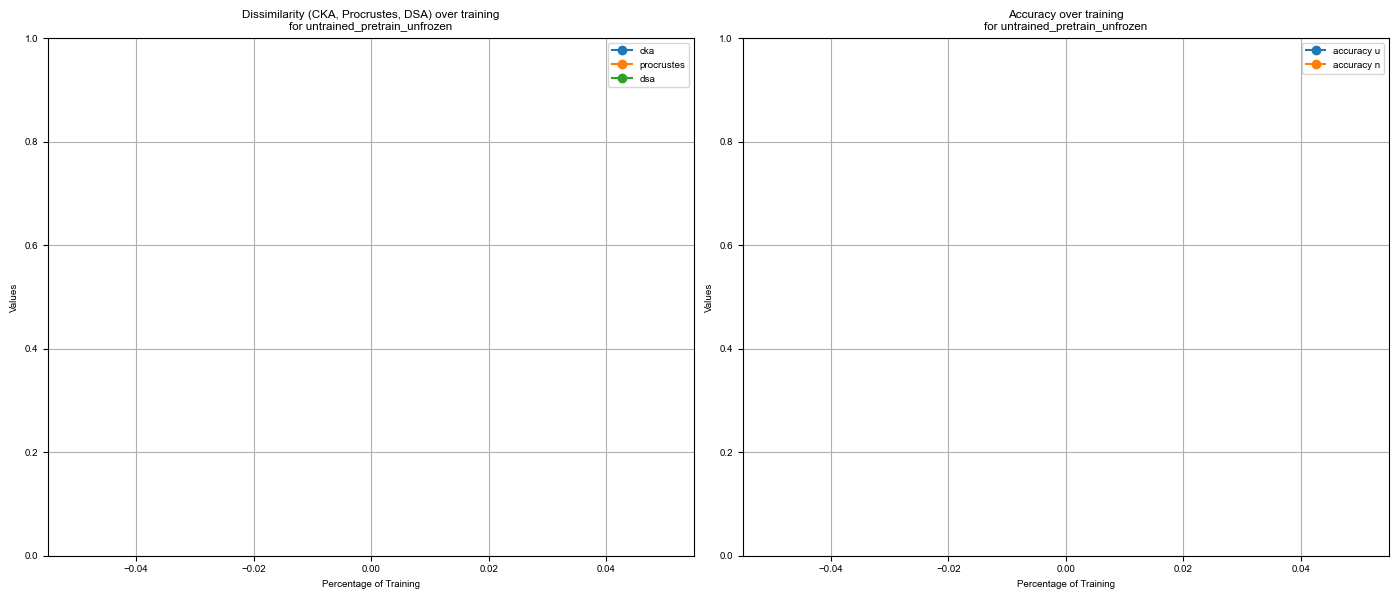

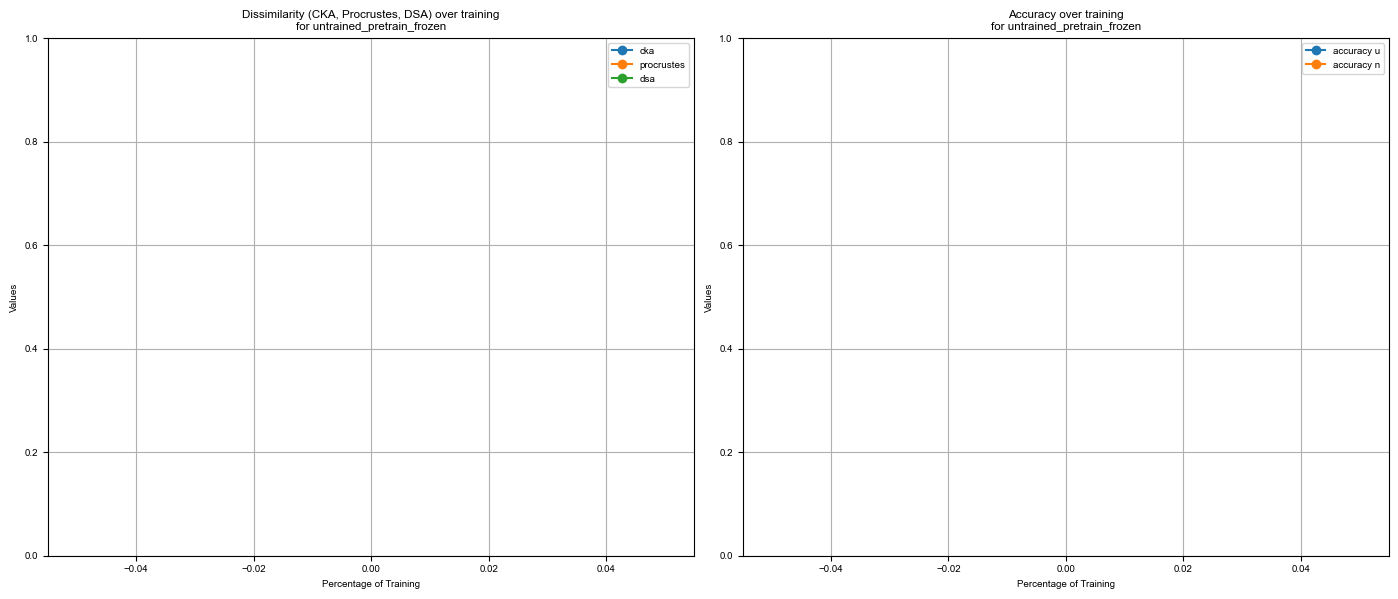

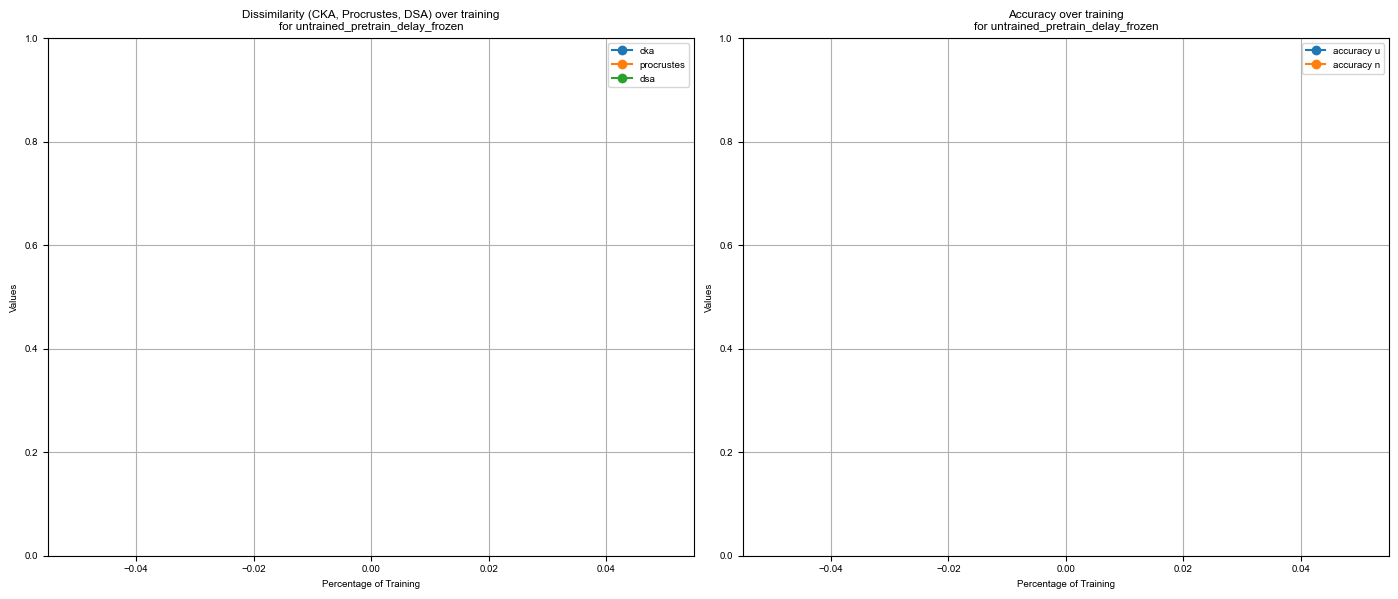

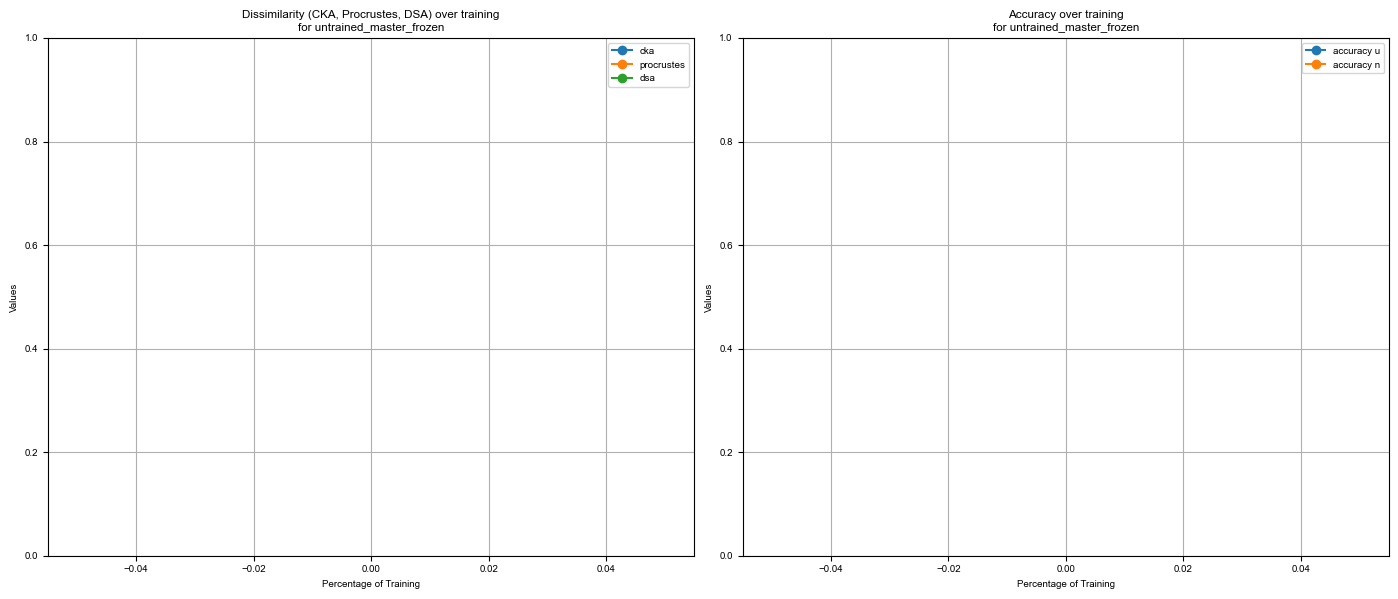

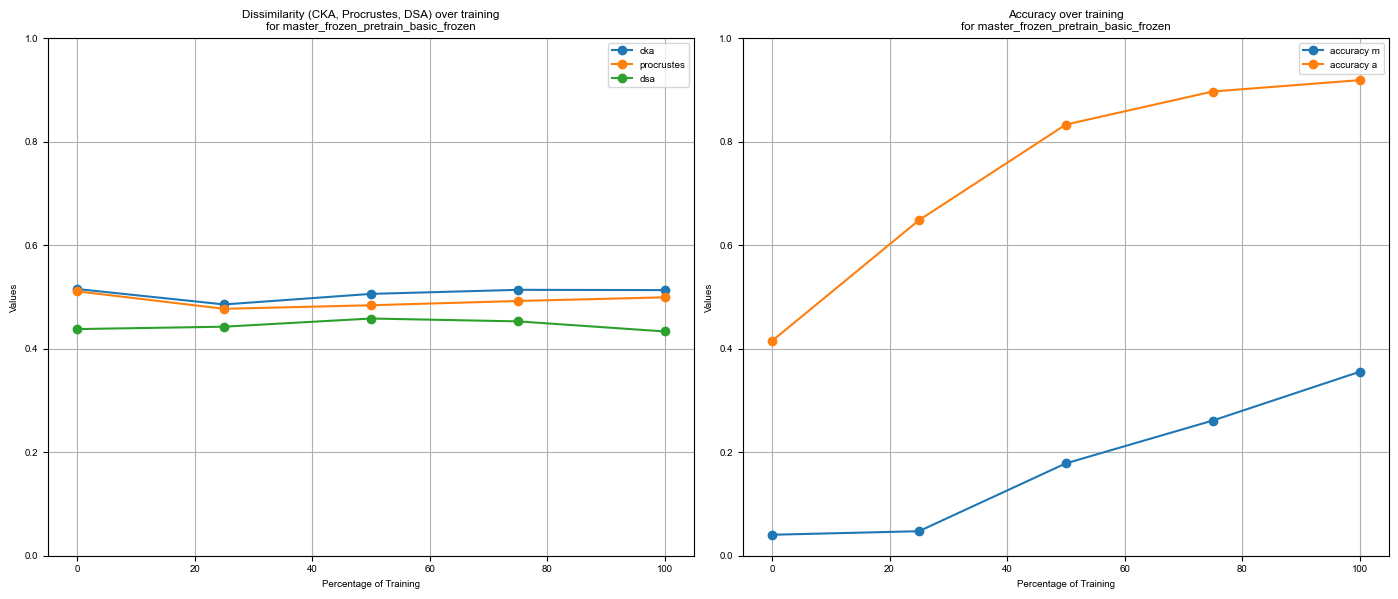

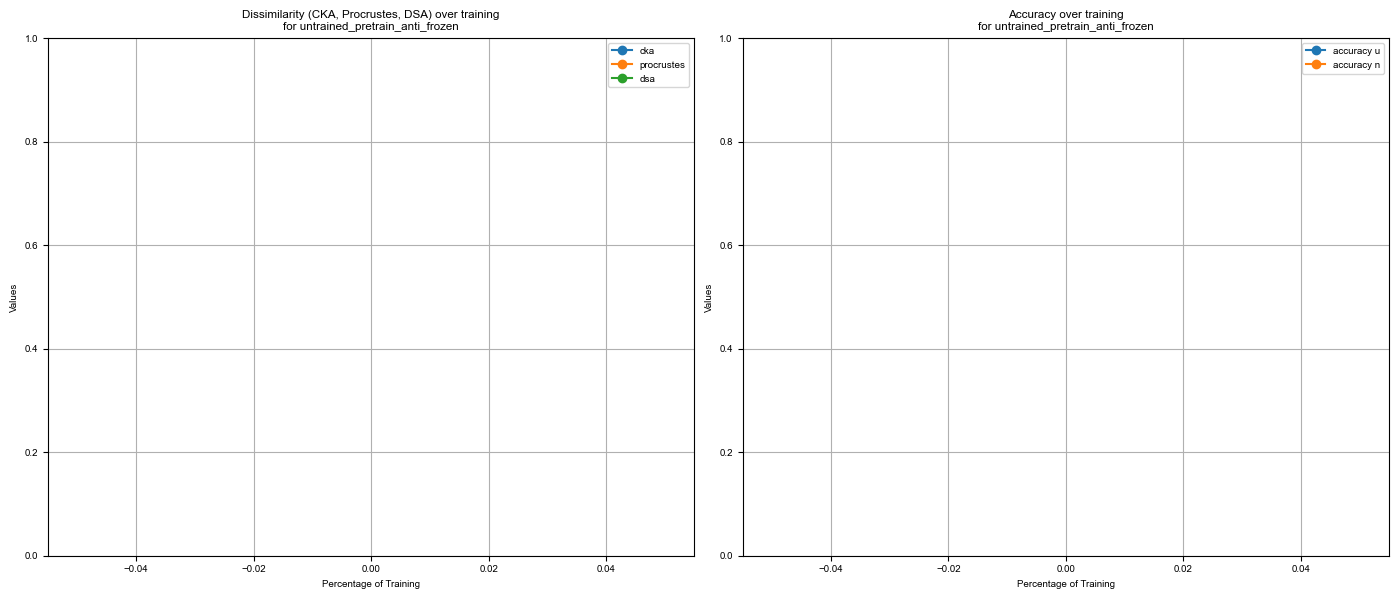

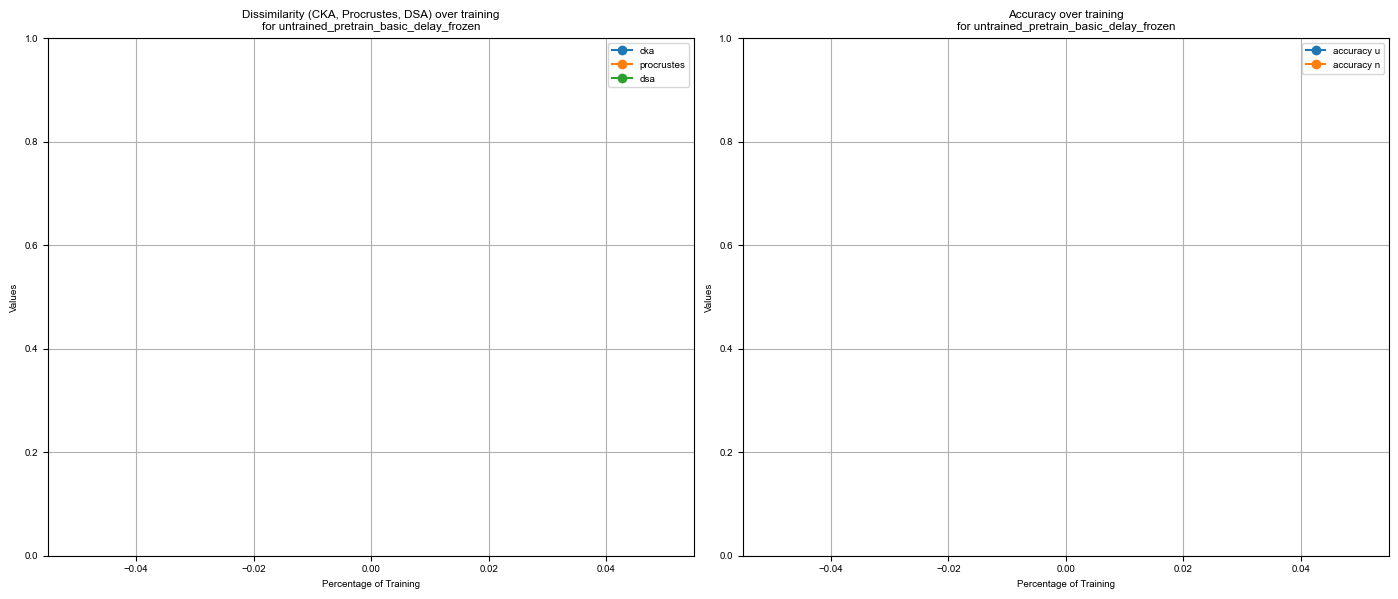

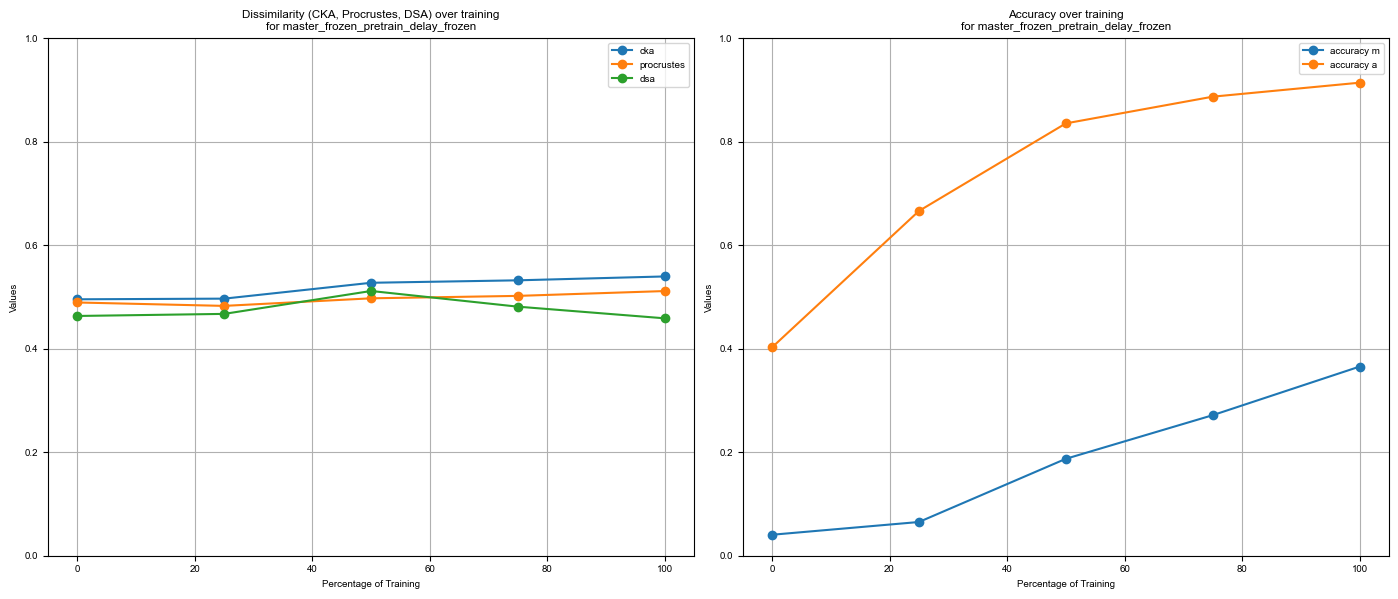

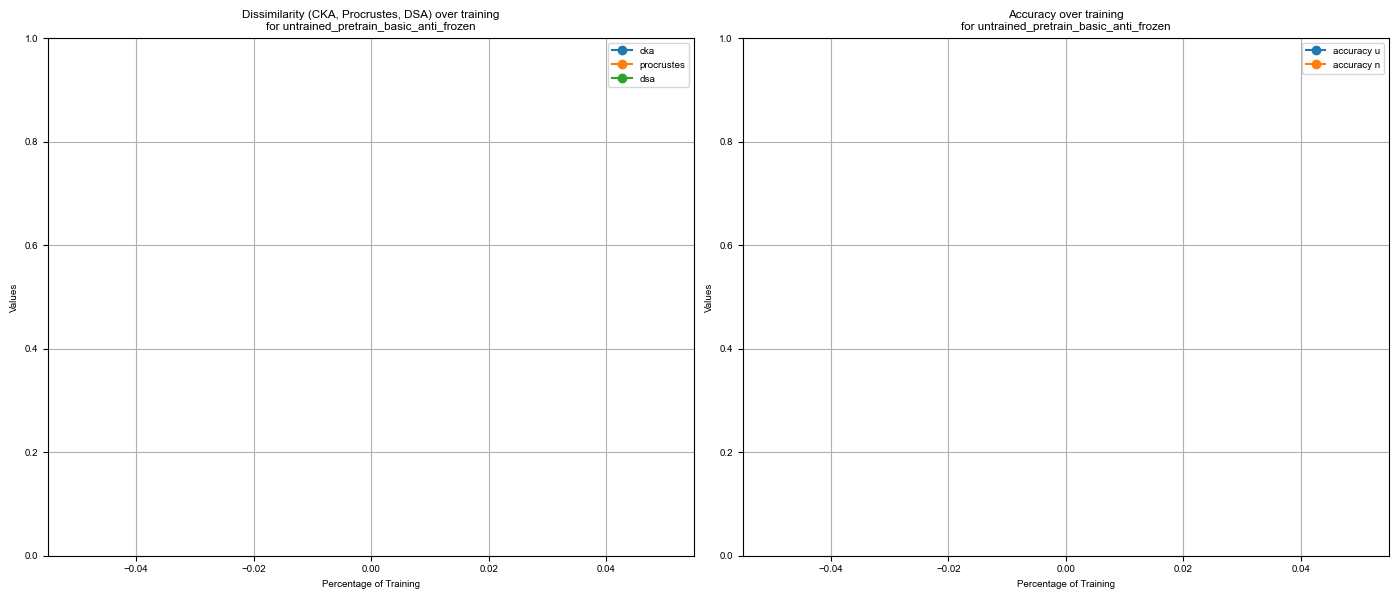

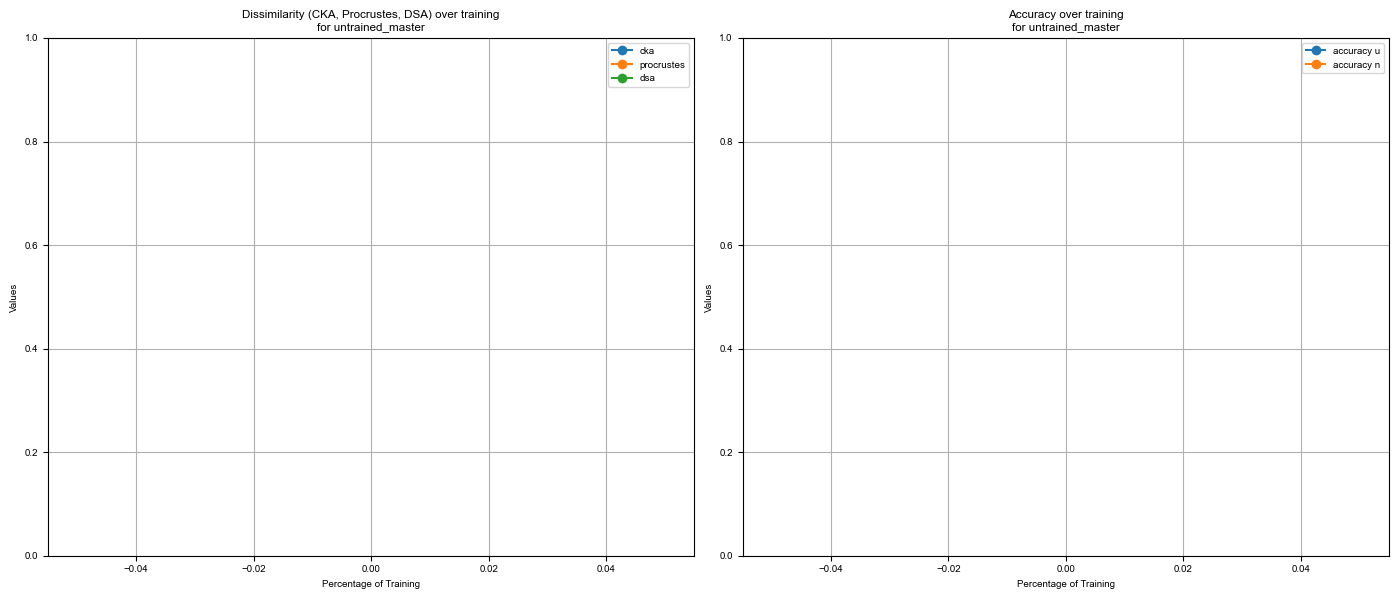

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    dissimilarities_interpolated = dissimilarities_groups[group_training]

    # X-axis values
    x_values = [0, 25, 50, 75, 100]

    # Measures for the two plots
    measures_plot1 = ["cka", "procrustes", "dsa"]
    measures_plot2 = ["accuracy_1", "accuracy_2"]

    # Create the figure and the two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot for the first set of measures
    for key in measures_plot1:
        values = dissimilarities_interpolated[key]
        axs[0].plot(x_values, list(values.values()), marker="o", label=key)

    axs[0].set_xlabel("Percentage of Training")
    axs[0].set_ylabel("Values")
    axs[0].set_title(
        "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
            group_training
        )
    )
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # Plot for the second set of measures
    for i, key in enumerate(measures_plot2):
        values = dissimilarities_interpolated[key]
        # Rename legend label for accuracy
        label = f"accuracy {group_training[i]}"
        axs[1].plot(x_values, list(values.values()), marker="o", label=label)

    axs[1].set_xlabel("Percentage of Training")
    axs[1].set_ylabel("Values")
    axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
    axs[1].set_ylim(0, 1)
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout to avoid overlapping elements
    plt.tight_layout()

    # Display the plots
    plt.show()


In [16]:
measures_diss = ["cka", "procrustes", "dsa"]
diss_cc = {measure: {shared: [] for shared in group_pairs} for measure in measures_diss}
for measure in diss_cc:
    for shared in diss_cc[measure]:
        for pair in group_pairs[shared]:
            name_1 = pair[0] + "_" + pair[1]
            name_2 = pair[1] + "_" + pair[0]
            if name_1 in dissimilarities_groups:
                diss_cc[measure][shared].append(
                    [x_values, dissimilarities_groups[name_1][measure]]
                )
            elif name_2 in dissimilarities_groups:
                diss_cc[measure][shared].append(
                    [x_values, dissimilarities_groups[name_2][measure]]
                )
        # once all the pairs are added, we can interpolate the values
        x_new = x_values
        y_new = []
        for i in range(len(x_values)):
            y_new.append(
                np.nanmedian([diss[1][i] for diss in diss_cc[measure][shared]])
            )
        diss_cc[measure][shared] = [x_new, y_new]

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_8600/1212983227.py:21: RuntimeWarning: All-NaN slice encountered
  np.nanmedian([diss[1][i] for diss in diss_cc[measure][shared]])
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


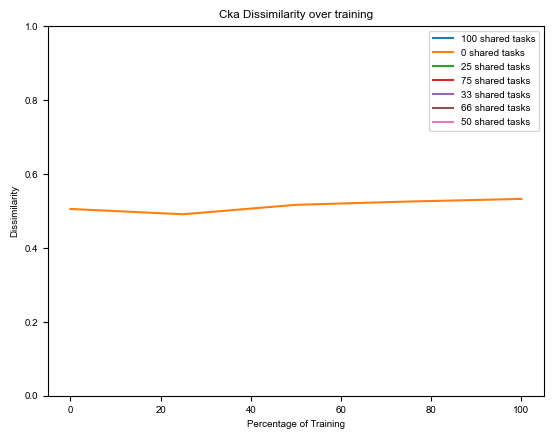

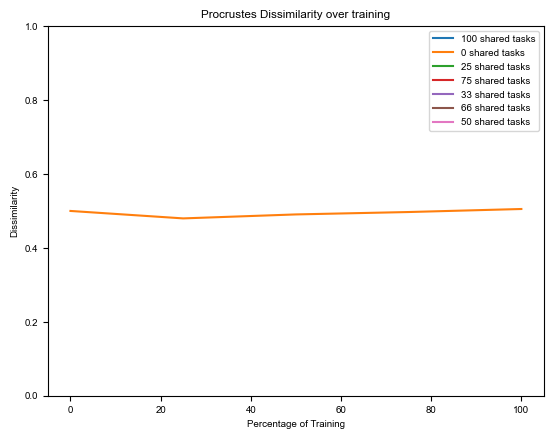

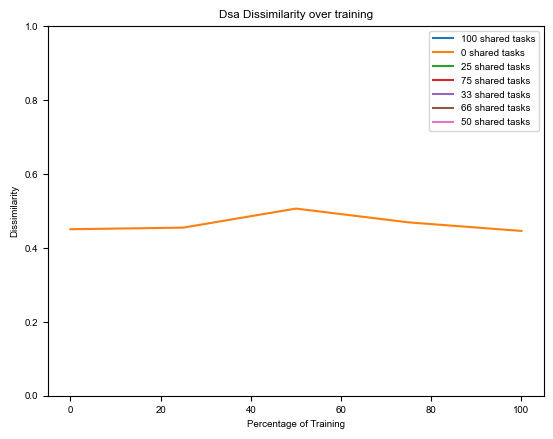

In [17]:
# do 3 plots, one for each measure, with one curve for each shared_task, x-axis is the percentage of training (x_values), y-axis is the dissimilarity value
for measure in diss_cc:
    for shared in diss_cc[measure]:
        x_new, y_new = diss_cc[measure][shared]
        plt.plot(x_new, y_new, label=f"{shared} shared tasks")
    plt.xlabel("Percentage of Training")
    plt.ylim(0, 1)
    plt.ylabel("Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity over training")
    plt.legend()
    plt.show()

### Dissimilarity within group 

In [18]:
path = f"../data/dissimilarities_within_learning/{taskset}/pretrain_frozen"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if file_path.endswith(".npz"):
            with np.load(file_path) as data:
                dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.median(np.stack(value, axis=0), axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '../data/dissimilarities_within_learning/PDM/pretrain_frozen/cka'

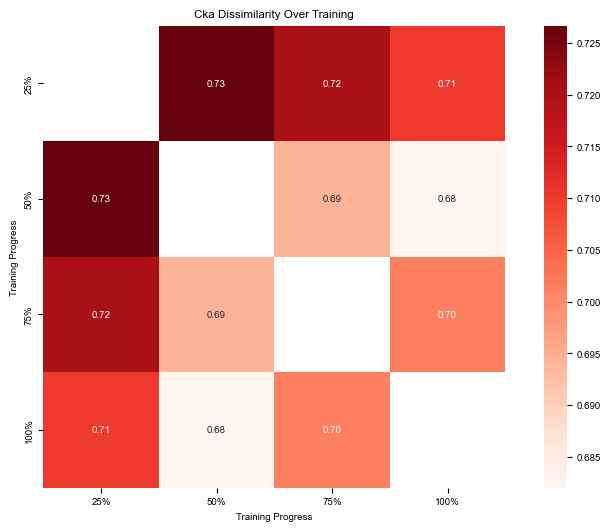

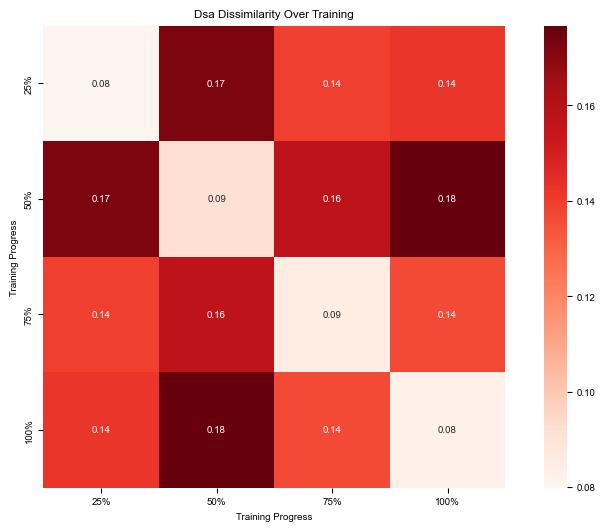

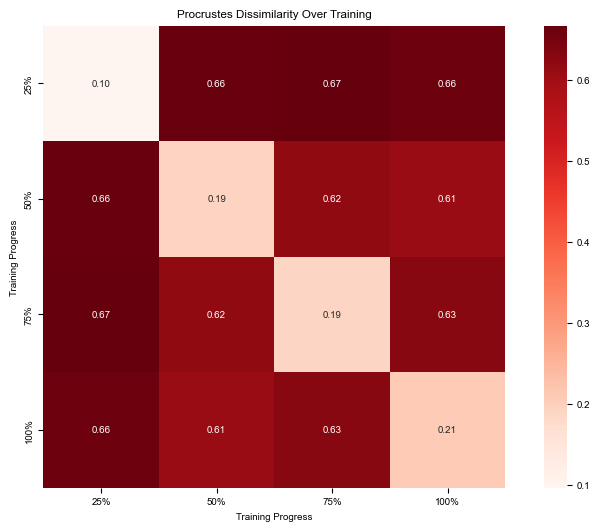

In [ ]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()